<img src="../assets/header_notebook.png" />
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>ESA - Black Sea Deoxygenation Emulator</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [1]:
# ----------
# Librairies
# ----------
import os
import sys
import cv2
import xarray
import random
import dawgz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Dawgz (jobs //)
from dawgz import job, schedule

# -------------------
# Librairies (Custom)
# -------------------
# Adding path to source folder to load custom modules
sys.path.insert(1, '../src/debs/')
sys.path.insert(1, '../scripts/')

# Loading libraries
from tools                import *
from metrics              import *
from dataset              import BlackSea_Dataset
from dataloader           import BlackSea_Dataloader

# -------
# Jupyter
# -------
%matplotlib inline
plt.rcParams.update({'font.size': 13})

# Making sure modules are reloaded when modified
%reload_ext autoreload
%autoreload 2

# Moving to the .py directory
%cd ../src/debs/

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
/Users/vikvador/Documents/🚀 - European Space Agency (GIT)/ESA---Black-Sea-Deoxygenation/src/debs


<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Scripts</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# Analyzing the data (1):
%run script_distribution.py --start_year        0 \
                            --end_year          0 \
                            --start_month       1 \
                            --end_month         2 \
                            --dawgz         False

In [ ]:
# Analyzing the data (2):
%run script_evolution.py --start_year        0 \
                         --end_year          0 \
                         --start_month       1 \
                         --end_month         2 \
                         --dawgz         False

In [ ]:
# Training a neural network:
%run script_training.py  --start_year                 0 \
                         --end_year                   0 \
                         --start_month                0 \
                         --end_month                  1 \
                         --inputs           temperature \
                         --problem       Classification \
                         --windows_input              1 \
                         --windows_output             1 \
                         --architecture            FCNN \
                         --batch_size                64 \
                         --epochs                    10 \
                         --kernel_size                3 \
                         --dawgz                  False

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Playground</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [2]:
# -----------------
#    Parameters
# -----------------
#
# Time window
month_starting = 1
month_ending   = 1
year_starting  = 0
year_ending    = 0

# Maximum depth observed for oxygen, what is left is masked [m] (Note: To observe only the continental shelf set it to ~200m).
depth_max_oxygen = 200

# ------------------
#  Loading the data
# ------------------
# Loading the different datasets
Dataset_phy = BlackSea_Dataset(year_start = year_starting, year_end = year_ending, month_start = month_starting,  month_end = month_ending, variable = "grid_T")
Dataset_bio = BlackSea_Dataset(year_start = year_starting, year_end = year_ending, month_start = month_starting,  month_end = month_ending, variable = "ptrc_T")

# Loading the different field values
data_temperature   = Dataset_phy.get_data(variable = "temperature", type = "surface", depth = None)
data_salinity      = Dataset_phy.get_data(variable = "salinity",    type = "surface", depth = None)
data_chlorophyll   = Dataset_bio.get_data(variable = "chlorophyll", type = "surface", depth = None)
data_kshort        = Dataset_bio.get_data(variable = "k_short",     type = "surface", depth = None)
data_klong         = Dataset_bio.get_data(variable = "k_long",      type = "surface", depth = None)
data_oxygen        = Dataset_bio.get_data(variable = "oxygen",      type = "bottom" , depth = depth_max_oxygen)

# Loading the black sea mask
bs_mask             = Dataset_phy.get_mask(depth = None)
bs_mask_with_depth  = Dataset_phy.get_mask(depth = depth_max_oxygen)

# --------------------
#  Preparing the data
# --------------------
# Loading the dataloader
BSD_loader = BlackSea_Dataloader(x = [data_temperature],
                                 y = data_oxygen,
                           bs_mask = bs_mask,
                bs_mask_with_depth = bs_mask_with_depth,
                              mode = "classification",
                        window_inp = 1,
                        window_out = 2)

# Retrieving the datasets
ds_validation = BSD_loader.get_dataloader("validation")
ds_train      = BSD_loader.get_dataloader("train")
ds_test       = BSD_loader.get_dataloader("test")

torch.Size([18, 1, 256, 576])
torch.Size([18, 2, 2, 256, 576])


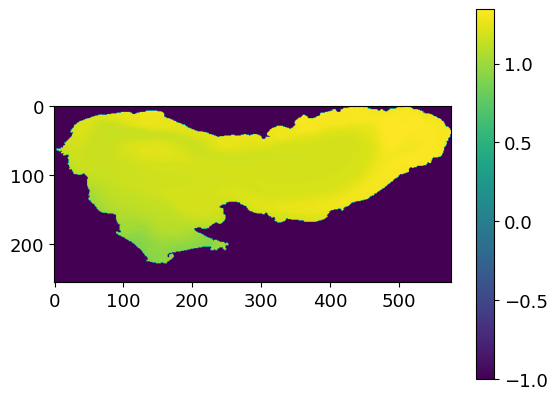

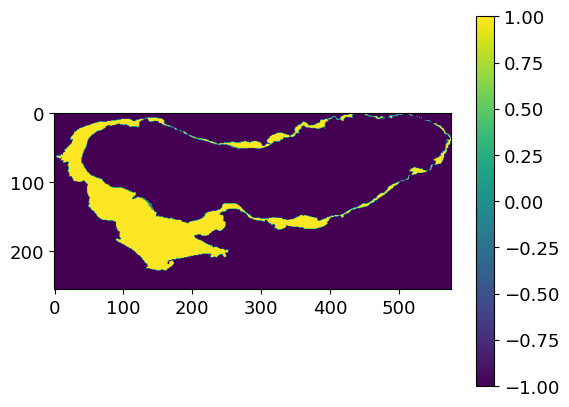

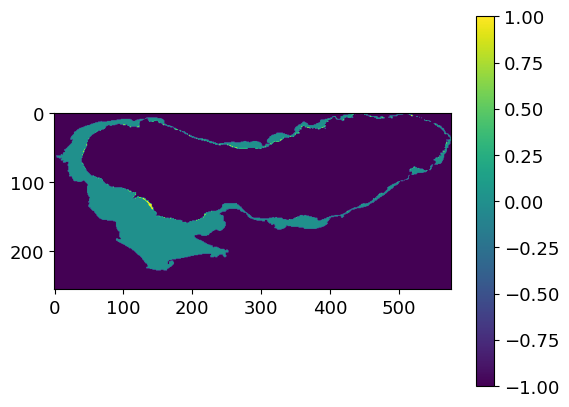

In [5]:
# Loading the dataloader
BSD_loader = BlackSea_Dataloader(x = [data_temperature],
                                 y = data_oxygen,
                           bs_mask = bs_mask,
                bs_mask_with_depth = bs_mask_with_depth,
                              mode = "classification",
                        window_inp = 1,
                        window_out = 2)

# Retrieving the datasets
ds_validation = BSD_loader.get_dataloader("validation")
ds_train      = BSD_loader.get_dataloader("train")
ds_test       = BSD_loader.get_dataloader("test")

for x, y in ds_train:

    print(x.shape)
    print(y.shape)

    plt.imshow(x[0, 0, :, :])
    plt.colorbar()
    plt.figure()
    plt.imshow(y[-1, 0, 0, :, :])
    plt.colorbar()
    plt.figure()
    plt.imshow(y[-1, 0, 1, :, :])
    plt.colorbar()

    break


<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Testing</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
#       TESTING
# --------------------
#
# Number of input variables
var_inputs = 2

# Window for the input
win_in = 2

# Window for the oxygen
win_out = 3

# Number of days
days = 14

# --------------------
#      GENERATING
# --------------------
# Generating fake data
fake_data_physical_variables = generateFakeDataset(resolution = 128, number_of_variables = var_inputs, number_of_samples=days)
fake_data_physical_oxygen    = generateFakeDataset(resolution = 128, number_of_variables = 1, number_of_samples=days, oxygen = True)

# Creation of the dataloaders
BSD_loader_fake_spatial = BlackSea_Dataloader(x = fake_data_physical_variables,
                                              y = fake_data_physical_oxygen[0],
                                           mask = np.ones(shape = (258, 258)),
                                           mode = "spatial",
                                     resolution = 128,
                                        window = win_in,
                                    window_out = win_out)

BSD_loader_fake_temporal = BlackSea_Dataloader(x = fake_data_physical_variables,
                                               y = fake_data_physical_oxygen[0],
                                            mask = np.ones(shape = (258, 258)),
                                            mode = "temporal",
                                      resolution = 128,
                                          window = win_in,
                                      window_out = win_out)


# OK
"""
for i in range(fake_data_physical_variables[0].shape[0]):

    plt.figure(figsize=(5, 5))
    plt.imshow(fake_data_physical_variables[1][i, :, :])
"""

# --------------------------------------------------------------------------------
#                                       SPATIAL
# --------------------------------------------------------------------------------
"""
for x, y in BSD_loader_fake_spatial.get_dataloader("train"):

    # Initial shapes
    print("Input shape: ", len(fake_data_physical_variables), fake_data_physical_variables[0].shape, "\nOutput shape: ", fake_data_physical_oxygen[0].shape)

    # Shapes (dataloader)
    print("Input shape: ", x.shape, "\nOutput shape: ", y.shape)

    # The total number of samples is
    # [Number of timesteps - number of input days (window) - number of output days (window_outgen) ] * number of regions
    #
    # Tests
    #
    # Number of variables
    assert x.shape[1] == var_inputs * win_in

    # Number of outputs
    assert y.shape[1] == win_out

    # Number of samples (must be divided by 2 for the validation and test)
    assert x.shape[0] == (fake_data_physical_variables[0].shape[0] - win_in - win_out) * int(256/128)

    # Checking that I have all the timesteps
    #
    # Looping over all the time steps
    for i in range(x.shape[0]):

        # Showing as a subplots the input and output pairs
        plt.figure(figsize=(14, 14))

        for j in range(var_inputs * win_in):
            plt.subplot(1, var_inputs * win_in + win_out, j+1)

            # Removing labels and tickz
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(x[i, j, :, :])

        for j in range(win_out):
            plt.subplot(1, var_inputs * win_in + win_out, var_inputs * win_in + j+1)
            # Removing labels and tickz
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)

            plt.imshow(y[i, j, :, :])

    # Idea check the validity using a trehsold to create a 1 0 matrix for comparison (otherwise it will  bug since you have normalized the data)

"""
# --------------------------------------------------------------------------------
#                                       SPATIAL
# --------------------------------------------------------------------------------
for x, y in BSD_loader_fake_temporal.get_dataloader("train"):

    # Initial shapes
    print("Input shape: ", len(fake_data_physical_variables), fake_data_physical_variables[0].shape, "\nOutput shape: ", fake_data_physical_oxygen[0].shape)

    # Shapes (dataloader)
    print("Input shape: ", x.shape, "\nOutput shape: ", y.shape)

    # Checking that I have all the regions
    #
    # Looping over all the time steps
    for i in range(x.shape[0]):

        # Showing as a subplots the input and output pairs
        plt.figure(figsize=(14, 14))

        for j in range(var_inputs * win_in):
            plt.subplot(1, var_inputs * win_in + win_out, j+1)

            # Removing labels and tickz
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(x[i, j, :, :])

        for j in range(win_out):
            plt.subplot(1, var_inputs * win_in + win_out, var_inputs * win_in + j+1)
            # Removing labels and tickz
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)

            plt.imshow(y[i, j, :, :])
